# Infinite Time-Evolving Block Decimation (iTEBD)

The goal of this algorithm is to find the ground-state for infinite systems exploiting translational invariance.
In particular, in this tutorial we will look for the GS of infinite-size spin chains.

We will take into account both Vidal's $\Gamma-\Lambda$ notation and Hasting's method.

## Vidal's $\Gamma-\Lambda$: AKLT MODEL

As we have already discussed, the AKLT is the chain of spin-1 that interact via nearest-neighbor interactions:

\begin{equation}
\hat{H}=\sum_{l}\Bigl[\hat{\bf{S}}_{l}\cdot\hat{\bf{S}}_{l+1}+\frac{1}{3}(\hat{\bf{S}}^2_{l}\cdot\hat{\bf{S}}^2_{l+1})\Bigr]
\end{equation}

First of all we will construct the interaction term. Be careful that the second spin operator $\hat{\bf{S}}_{l+1}$ should be Hermitian conjugated, i.e. complex conjugated + transposed. As the interaction term acts on two sites, we consider a unit cell of two sites. Initialize the tensors, which would consitute the ket tensor for the unit cell, with random tensors. The conditions to be fulfilled as the ket tensor, such as the left- or right-normalization, will be automatically achieved by the imaginary time evolution.

In [1]:
# Include all the relevant modules
include("../JTensorNetwork.jl");
using PyPlot

In [2]:
# Local operators
S,Id = getLocalSpace("Spin",1);

# Heisenberg interaction as two-site gate S*S'
HSS = contract(S,3,[2],permutedims(conj(S),[3 2 1]),3,[2]);
# (S*S')^2 interaction
HSS2 = contract(HSS, 4, [2 4], HSS,4,[1 3],[1 3 2 4]);
#        2       4
#        ^       ^
#        |       |
#     [ HSS or HSS2 ]
#        |       |
#        ^       ^
#        1       3

# AKLT
H = HSS + HSS2/3;

In [3]:
# iTEBD parameters
Nkeep     =   10;
beta_init =    1;
beta_fin  = 0.01;
Nstep     =  500;
betas = beta_init*((beta_fin/beta_init).^range(0,stop=1,length=Int(Nstep))); # discrete imaginary time steps
                                                                             # decasy slowly but exponentially

# Initialize with random Lambda and Gamma
# For convenience Lambda[1]->even bonds, Lambda[2]->odd bonds
Lambda = Vector{Union{Nothing, Array{Float64,1}}}(nothing, 2);
Gamma = Vector{Union{Nothing, Array{Float64,3}}}(nothing, 2);
for itn in 1:2
    Lambda[itn] = rand(Nkeep);
    Gamma[itn]  = rand(Nkeep,size(Id,2),Nkeep);
end

# Start iTEBD
Lambda,Gamma,Es = iTEBD_GS(Lambda,Gamma,H,Nkeep,betas);

iTEBD ground state search: Vidal's method.
# of sites = 2, Bond dim. Nkeep = 10, # of imag. time steps = 500
27/11/2020 16:16:8 (GMT) | # 500/500, E = -0.6666666666666666
Elapsed time = 3.655478000640869 s


The ground state of the AKLT model is the AKLT state. We will now compare the iTEBD result with the exact results.

First, let's compare the energy: the exact ground state energy per site for the AKLT state is -2/3.

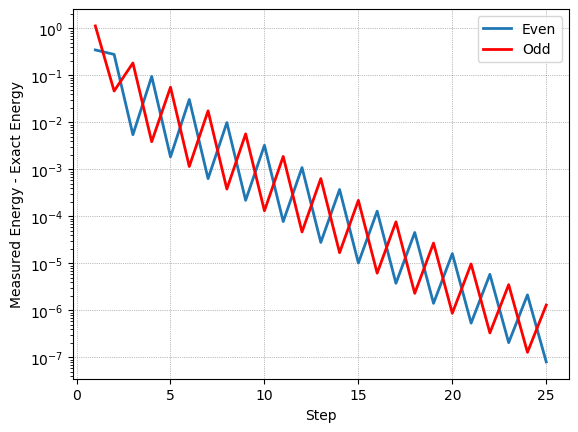

In [4]:
Eexact = -2/3;
x = (1:size(Es,1));
Eeven = Es[:,1].-Eexact;
Eodd  = Es[:,2].-Eexact;

ylabel("Measured Energy - Exact Energy");
xlabel("Step");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x[1:25],Eeven[1:25],linewidth=2.0,label="Even");
semilogy(x[1:25],Eodd[1:25],linewidth=2.0,label="Odd",color="red");
legend(loc="upper rigth");

We observe that the energies at each bond (each column of Es) converge to the exact value with oscillations: when we apply the imaginary time evolution to the tensors sandwiching one bond (say even bond), the time evolution operator changes the tensors in a way that the energy for the even bond decreases at the cost of increasing the energy of the odd bond.

To further see the convergence, we average the energies over even and odd bonds, which is equivalent to the energy per site for infinite systems. Actually, the energy values (E = ...) shown along the progress are averaged ones at those steps. We plot the error of the energy per site in log scale:

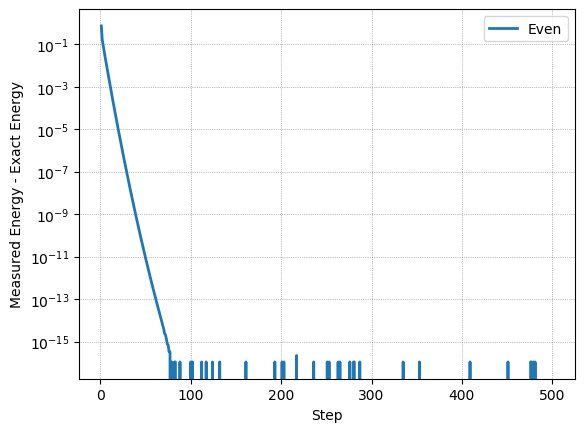

In [5]:
Eexact = -2/3;
x = (1:size(Es,1));
Emean = mean(Es,dims=2).-Eexact;

ylabel("Measured Energy - Exact Energy");
xlabel("Step");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x,Emean,linewidth=2.0,label="Even");
legend(loc="upper rigth");

The energy per site well converges to the exact value -2/3, up to double precision ~$10^{-16}$!

We now analyze the tensors. We first obtain the left-normalized ket tensor by contracting Lambda[2] and Gamma[1], which is associated with one site within the unit cell of two sites:

In [6]:
DL2 = zeros(length(Lambda[2]),length(Lambda[2]))
for i in 1:length(Lambda[2])
    DL2[i,i] = Lambda[2][i];
end
A1 = contract(DL2,2,[2],Gamma[1],3,[1])

2×3×2 Array{Float64,3}:
[:, :, 1] =
  0.0          -0.0771419   0.809175
 -9.92506e-16  -0.572173   -0.109095

[:, :, 2] =
 -0.109095   0.572173   -1.55929e-15
 -0.809175  -0.0771419   2.19347e-16

In [7]:
# Check if left-normalized
T = contract(conj(A1),3,[1 2],A1,3,[1 2])

2×2 Array{Float64,2}:
  1.0          -1.89652e-16
 -1.89652e-16   1.0        

Notice that in Vidal's convention, Lambda*Gamma is left-normalized while Gamma*Lambda is right-normalized. However in this case the ket tensor Lambda*Gamma is also right-normalized: this is due to the non-trivial nature of the AKLT state.

In [8]:
# check if right-normalized
T = contract(conj(A1),3,[2 3],A1,3,[2 3])

2×2 Array{Float64,2}:
 1.0          2.12654e-17
 2.12654e-17  1.0        

In [9]:
# Another site
DL1 = zeros(length(Lambda[1]),length(Lambda[1]))
for i in 1:length(Lambda[1])
    DL1[i,i] = Lambda[1][i];
end
A2 = contract(DL1,2,[2],Gamma[2],3,[1])

2×3×2 Array{Float64,3}:
[:, :, 1] =
 0.809175      0.0771419   1.21431e-16
 2.69724e-16  -0.572173   -0.109095   

[:, :, 2] =
 -0.109095     0.572173   -1.1588e-15
 -1.18436e-17  0.0771419  -0.809175  

In [10]:
# Check if left-normalized
T = contract(conj(A2),3,[1 2],A2,3,[1 2])

2×2 Array{Float64,2}:
 1.0          2.95486e-16
 2.95486e-16  1.0        

In [11]:
# check if right-normalized
T = contract(conj(A2),3,[2 3],A2,3,[2 3])

2×2 Array{Float64,2}:
  1.0          -7.72329e-17
 -7.72329e-17   1.0        

There are only two finite singular values that are identical: they are the Schmidt coefficients of the valence bond state, which is the singlet of two spin-1/2

In [12]:
# Singular Values
Lambda[1]'

1×2 Adjoint{Float64,Array{Float64,1}}:
 0.707107  0.707107

In [13]:
Lambda[2]'

1×2 Adjoint{Float64,Array{Float64,1}}:
 0.707107  0.707107

Recall the AKLT state we used in the precedent tutorial:

In [14]:
# Initialize the local AKLT tensor
    AKLT = zeros(2,3,2);

    # local spin Sz = -1
    AKLT[2,1,1] = -sqrt(2/3);
    # local spin Sz = 0
    AKLT[1,2,1] = -1/sqrt(3);
    AKLT[2,2,2] = +1/sqrt(3);
    # local spin Sz = +1
    AKLT[1,3,2] = sqrt(2/3);

AKLT

2×3×2 Array{Float64,3}:
[:, :, 1] =
  0.0       -0.57735  0.0
 -0.816497   0.0      0.0

[:, :, 2] =
 0.0  0.0      0.816497
 0.0  0.57735  0.0     

Often, the tensors AKLT and A1 (or A2) may look different, since there are arbitrary degrees of freedom associated with the unitary transformation on the Hilbert space of the left/right legs (so-called bond space), which is called gauge transformation.
Also, there is even-odd oscillation in our iTEBD result: Two ket tensors within the unit cell are not identical. This even-odd oscillation naturally comes from our consideration of the unit cell of two sites.

Another way to analyze the tensor is to study the transfer operator. The eigenvalues of the transfer operator are independent from the gauge transformation on the bond space. Due to the even-odd oscillation, we will consider the transfer operator for the whole unit cell (i.e., two sites).

In [15]:
DL1 = zeros(length(Lambda[1]),length(Lambda[1]))
for i in 1:length(Lambda[1])
    DL1[i,i] = Lambda[1][i];
end
DL2 = zeros(length(Lambda[2]),length(Lambda[2]))
for i in 1:length(Lambda[2])
    DL2[i,i] = Lambda[2][i];
end

# Contract Gamma*Lambda*Gamma*Lambda
T = contract(Gamma[1],3,[3],DL1,2,[1]);
T = contract(T,3,[3],Gamma[2],3,[1]);
T = contract(T,4,[4],DL2,2,[1]);

# Transfer operator
W = contract(conj(T),4,[2 3],T,4,[2 3],[1 3 2 4]);

# Reshape W as matrix
MW = reshape(W,(size(W,1)*size(W,2),size(W,3)*size(W,4)));
DW,VW = eigen(MW);
ids = sortperm(DW,rev=true);
VW = VW[:,ids];
DW = DW[ids];

Note that eigen function computes the eigenvectors V and eigenvalues D of matrix M such that M*V = V*D, i.e., the eigenvectors are acted onto the right side of M. The eigenvalues of the transfer operator per one site can be obtained as the square roots of the eigenvalues for two sites:

In [16]:
sqrt.(DW)'

1×4 Adjoint{Float64,Array{Float64,1}}:
 1.0  0.333333  0.333333  0.333333

The largest eigenvalue of the transfer operator per one site should be one, and the eigenvector associated with that eigenvalue should be proportional to the identity matrix, after reshaping.

In [17]:
VM2 = reshape(VW[:,1],(size(W,1),size(W,2)))

2×2 Array{Float64,2}:
 -0.707107     -8.85115e-17
 -4.90654e-17  -0.707107   

This "eigenvector" means that the identity matrix (rank-2) acted onto the transfer operator (rank-4) on the right side is "transferred" to the identity matrix (rank-2) on the left side. It means nothing but the right- normalization of the tensor Gamma*Lambda*Gamma*Lambda.
The other eigenvalues, which are three degenerate 1/3's, are identical.

## Vidal's $\Gamma-\Lambda$: Heisenberg spin-1 model

Consider the spin-1 Heisenberg model:

\begin{equation}
\hat{H}=\sum_{l}\hat{\bf{S}}_{l}\cdot\hat{\bf{S}}_{l+1}
\end{equation}

The ground state of this model lies also in the Haldane phase which has symmetry-protected topological order, as the AKLT state does. We use the iTEBD to obtain the ground state and its energy. Here we set larger Nkeep and more Nstep than in the AKLT example. In accordance with larger Nstep, we also decrease the final imaginary time step size beta_fin.

In [18]:
# Local operators
S,Id = getLocalSpace("Spin",1);

# Heisenberg interaction as two-site gate S*S'
H = contract(S,3,[2],permutedims(conj(S),[3 2 1]),3,[2]);

# iTEBD parameters
Nkeep     =   30;
beta_init =    1;
beta_fin  = 1e-6;
Nstep     =  3e3;
betas = beta_init*((beta_fin/beta_init).^range(0,stop=1,length=Int(Nstep))); # discrete imaginary time steps
                                                                             # decasy slowly but exponentially

# Initialize with random Lambda and Gamma
# For convenience Lambda[1]->even bonds, Lambda[2]->odd bonds
Lambda = Vector{Union{Nothing, Array{Float64,1}}}(nothing, 2);
Gamma = Vector{Union{Nothing, Array{Float64,3}}}(nothing, 2);
for itn in 1:2
    Lambda[itn] = rand(Nkeep);
    Gamma[itn]  = rand(Nkeep,size(Id,2),Nkeep);
end

# Start iTEBD
Lambda,Gamma,Es = iTEBD_GS(Lambda,Gamma,H,Nkeep,betas);

iTEBD ground state search: Vidal's method.
# of sites = 2, Bond dim. Nkeep = 30, # of imag. time steps = 3000
27/11/2020 16:18:5 (GMT) | # 500/3000, E = -1.393630328332741
27/11/2020 16:18:42 (GMT) | # 1000/3000, E = -1.4008237233122312
27/11/2020 16:19:19 (GMT) | # 1500/3000, E = -1.4014188026819563
27/11/2020 16:19:56 (GMT) | # 2000/3000, E = -1.401477082343383
27/11/2020 16:20:33 (GMT) | # 2500/3000, E = -1.4014828940788182
27/11/2020 16:21:11 (GMT) | # 3000/3000, E = -1.4014834746889693
Elapsed time = 223.90577793121338 s


The ground-state energy of the spin-1 Heisenberg model is -1.401484039 [S. R. White and D. A. Huse, Phys. Rev. B 48, 3844 (1993)]: this value has been obtained by extrapolating the DMRG result of finite-sized systems to the thermodynamic limit.

The energies for each bond converge to the exact value, with oscillation:

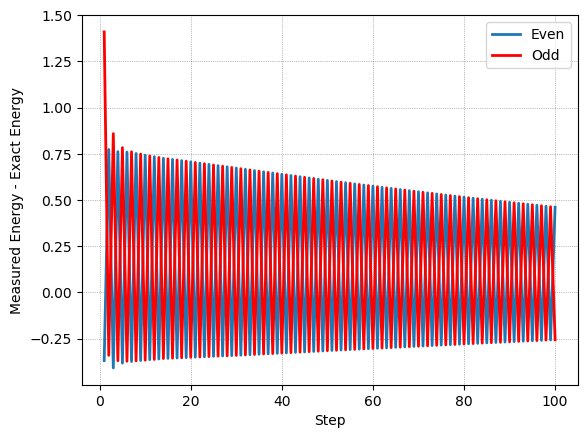

In [19]:
Eexact = -1.401484039;
x = (1:size(Es,1));
Eeven = Es[:,1].-Eexact;
Eodd  = Es[:,2].-Eexact;

ylabel("Measured Energy - Exact Energy");
xlabel("Step");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x[1:100],Eeven[1:100],linewidth=2.0,label="Even");
plot(x[1:100],Eodd[1:100],linewidth=2.0,label="Odd",color="red");
legend(loc="upper rigth");

And the averaged energy, i.e., the energy per site, converges to the exact value from above; that is, the numerically obtained energy per site is larger than the the exact value:

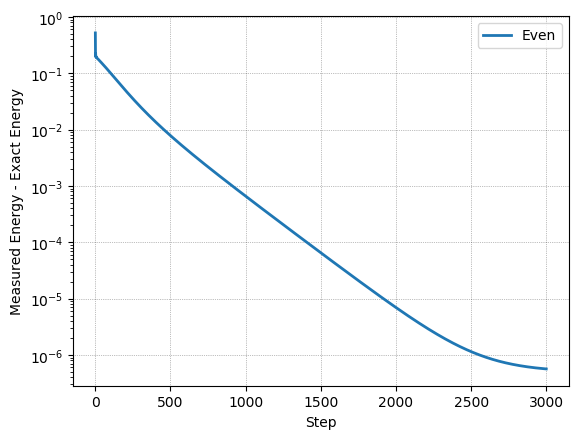

In [20]:
Eexact = -1.401484039;
x = (1:size(Es,1));
Emean = mean(Es,dims=2).-Eexact;

ylabel("Measured Energy - Exact Energy");
xlabel("Step");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x,Emean,linewidth=2.0,label="Even");
legend(loc="upper rigth");

The error of energy can be further decreased by several ways:
(i) decrease beta_min,
(ii) increase Nstep, or 
(iii) increase Nkeep.

The result singular values, stored in Lambda, are decaying exponentially. The exponential decay corresponds to the nature of the system which is gapped. The logarithms of the singular values, called entanglement spectrum, have certain structure: 

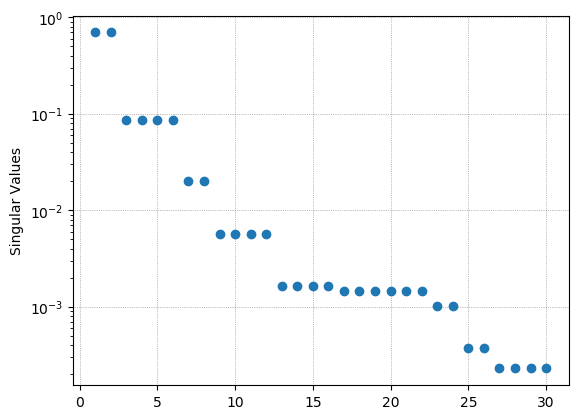

In [21]:
y = Lambda[1][:];
x = (1:1:length(y));
ylabel("Singular Values");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x,y,linewidth=0,marker="o");

We see that they have even degeneracies: 2, 4, 2, 4, 4, 6, and so on. Such even degeneracies are indicators of topological nature of the system [F. Pollmann, A. M. Turner, E. Berg, and M. Oshikawa, Phys. Rev. B 81, 064439 (2010)].

The eigenvector of the transfer operator associated with the largest eigenvalue needs to be proportional to the identity matrix after reshaping, since it indicates the left- or right-normalization. In this case:

In [22]:
DL1 = zeros(length(Lambda[1]),length(Lambda[1]))
for i in 1:length(Lambda[1])
    DL1[i,i] = Lambda[1][i];
end
DL2 = zeros(length(Lambda[2]),length(Lambda[2]))
for i in 1:length(Lambda[2])
    DL2[i,i] = Lambda[2][i];
end

# Contract Gamma*Lambda*Gamma*Lambda
T = contract(Gamma[1],3,[3],DL1,2,[1]);
T = contract(T,3,[3],Gamma[2],3,[1]);
T = contract(T,4,[4],DL2,2,[1]);

# Transfer operator
W = contract(conj(T),4,[2 3],T,4,[2 3],[1 3 2 4]);

# Reshape W as matrix
MW = reshape(W,(size(W,1)*size(W,2),size(W,3)*size(W,4)));
DW,VW = eigen(MW);
DW = real(DW);
VW = real(VW);
ids = sortperm(DW,rev=true);
VW = VW[:,ids];
DW = DW[ids];
DW[1]

1.0000000000002716

In [23]:
# VW should be proportional to the identity if tensors are "orthogonal"
VM2 = reshape(VW[:,1],(size(W,1),size(W,2)));
# as the matrix VM2 is large, let's compare only the differences deviation from I
VM2diff = abs.((tr(VM2)/size(VM2,1))* Matrix(I, size(VM2,1), size(VM2,2)).-VM2);
mean(VM2diff[:])

1.6291944120699598e-8

The eigenvector of the transfer operator associated with the largest eigenvalue ("dominant eigenvector" of the transfer operator) is proportional to the identity matrix up to numerical error.

## Hasting's method:

We will now compare the Hasting algorithm for the Heisenberg spin-1 model.

In [24]:
## Initialization

# Local operators
S,Id = getLocalSpace("Spin",1);

# Heisenberg interaction as two-site gate S*S'
H = contract(S,3,[2],permutedims(conj(S),[3 2 1]),3,[2]);

# iTEBD parameters
Nkeep     =   30;
beta_init =    1;
beta_fin  = 1e-6;
Nstep     =  3e3;
betas = beta_init*((beta_fin/beta_init).^range(0,stop=1,length=Int(Nstep))); # discrete imaginary time steps
                                                                             # decasy slowly but exponentially

# Initialize with random Lambda and Gamma
# For convenience Lambda[1]->even bonds, Lambda[2]->odd bonds
Lambda = Vector{Union{Nothing, Array{Float64,1}}}(nothing, 2);
Gamma = Vector{Union{Nothing, Array{Float64,3}}}(nothing, 2);
for itn in 1:2
    Lambda[itn] = rand(Nkeep);
    Gamma[itn]  = rand(Nkeep,size(Id,2),Nkeep);
end

In [25]:
# Vidal's method
# Start iTEBD
Lambda1,Gamma1,Es1 = iTEBD_GS(Lambda,Gamma,H,Nkeep,betas);

iTEBD ground state search: Vidal's method.
# of sites = 2, Bond dim. Nkeep = 30, # of imag. time steps = 3000
27/11/2020 16:22:23 (GMT) | # 500/3000, E = -1.3936303283327414
27/11/2020 16:23:0 (GMT) | # 1000/3000, E = -1.4008237233122307
27/11/2020 16:23:38 (GMT) | # 1500/3000, E = -1.4014188026819576
27/11/2020 16:24:20 (GMT) | # 2000/3000, E = -1.401477082343383
27/11/2020 16:24:57 (GMT) | # 2500/3000, E = -1.401482894078818
27/11/2020 16:25:35 (GMT) | # 3000/3000, E = -1.4014834746889697
Elapsed time = 229.08290195465088 s


In [26]:
# Hasting's method
Lambda2,Gamma2,Es2 = iTEBD_GS(Lambda,Gamma,H,Nkeep,betas,"Hastings");

iTEBD ground state search: Hastings' method.
# of sites = 2, Bond dim. Nkeep = 30, # of imag. time steps = 3000
27/11/2020 16:27:57 (GMT) | # 500/3000, E = -1.393630328332741
27/11/2020 16:28:35 (GMT) | # 1000/3000, E = -1.4008237233122323
27/11/2020 16:29:14 (GMT) | # 1500/3000, E = -1.4014188026819596
27/11/2020 16:29:50 (GMT) | # 2000/3000, E = -1.4014770823433822
27/11/2020 16:30:26 (GMT) | # 2500/3000, E = -1.40148289407882
27/11/2020 16:31:2 (GMT) | # 3000/3000, E = -1.4014834746889706
Elapsed time = 220.85632705688477 s


We first compare the energies: take the absolute values of the error, since the Hastings' method may underestimate the energy expectation value.

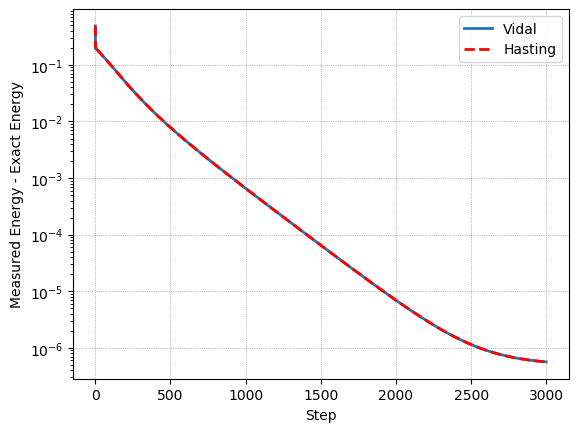

In [27]:
Eexact = -1.401484039;
x = (1:size(Es1,1));
Emean1 = mean(Es1,dims=2).-Eexact;
Emean2 = mean(Es2,dims=2).-Eexact;

ylabel("Measured Energy - Exact Energy");
xlabel("Step");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x,Emean1,linewidth=2.0,label="Vidal");
semilogy(x,Emean2,"--",linewidth=2.0,color="red",label="Hasting");
legend(loc="upper rigth");

Next compare the singular values:

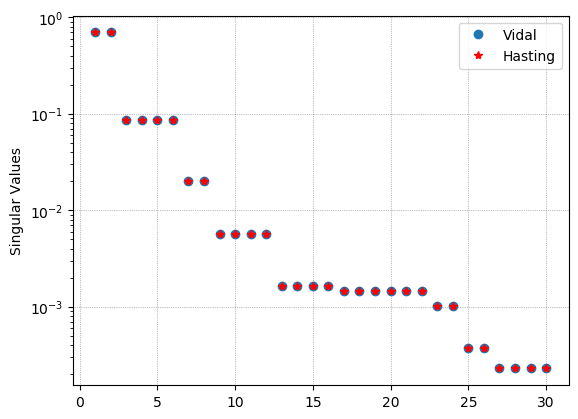

In [28]:
y1 = Lambda1[1][:];
y2 = Lambda2[1][:];
x = (1:1:length(y1));
ylabel("Singular Values");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x,y1,linewidth=0,marker="o",label="Vidal");
semilogy(x,y2,linewidth=0,marker="*",label="Hasting",color="red");
legend(loc="upper rigth");

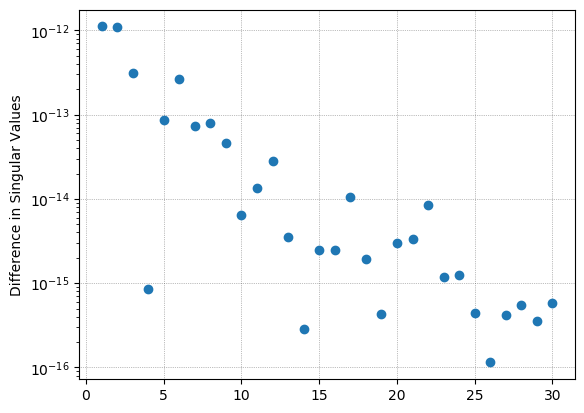

In [29]:
ydiff = abs.(Lambda1[1][:].-Lambda2[1][:]);
x = (1:1:length(ydiff));
ylabel("Difference in Singular Values");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x,ydiff,linewidth=0,marker="o");

The two results do no differ except for machine precision.

We next compute the spin-spin correlation function $<\hat{S}^z_l\hat{S}^z_{l+1}>$:

In [30]:
# Set the maximum distance from site l
nmax = 30;

# Initialize the correlation function
SzSzval = zeros(nmax);
Sz = S[:,3,:];

DL2 = zeros(length(Lambda1[2]),length(Lambda1[2]));
for i in 1:length(Lambda1[2])
    DL2[i,i] = Lambda1[2][i]^2;
end

# Compute the correlation
T = updateLeft(DL2,2,Gamma1[1],Sz,2,Gamma1[1]);
for it in 1:nmax
    DL = zeros(length(Lambda1[mod(it+1,2)+1]),length(Lambda1[mod(it+1,2)+1]));
    for i in 1:length(Lambda1[mod(it+1,2)+1])
        DL[i,i] = Lambda1[mod(it+1,2)+1][i];
    end
    A = contract(DL,2,[2],Gamma1[mod(it,2)+1],3,[1]);
    DL = zeros(length(Lambda1[mod(it,2)+1]),length(Lambda1[mod(it,2)+1]));
    for i in 1:length(Lambda1[mod(it,2)+1])
        DL[i,i] = Lambda1[mod(it,2)+1][i]^2;
    end
    SzSzval[it] = tr(updateLeft(T,2,A,Sz,2,A)*DL);
    T = updateLeft(T,2,A,[],[],A);
end

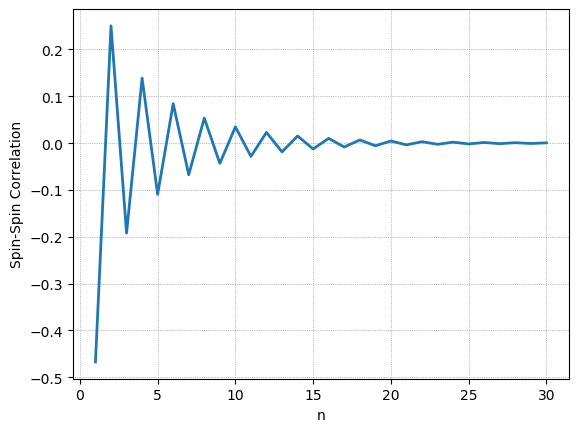

In [31]:
x = (1:1:length(SzSzval));
ylabel("Spin-Spin Correlation");
xlabel("n")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,SzSzval,linewidth=2.0);

The correlation function shows even-odd oscillations, which is intrinsic to anti-ferromagnetic correlations. To focus on the envelope of the exponential dependence, we multiply the alternating sign factor:

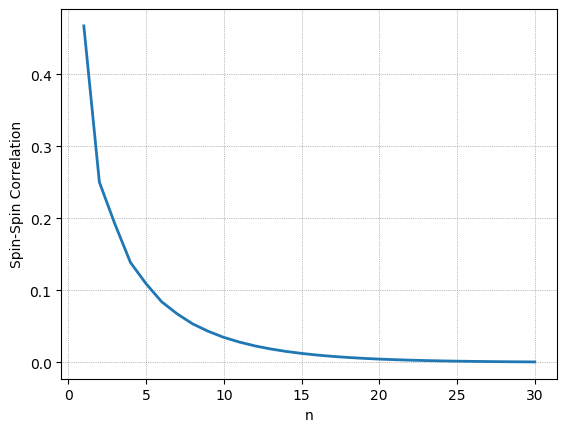

In [32]:
x = (1:1:length(SzSzval));
SzSzval2 = SzSzval.*((-1).^(1:nmax));
ylabel("Spin-Spin Correlation");
xlabel("n")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(x,SzSzval2,linewidth=2.0);

For large distance n between the sites on which the spin operators act, the correlation decays exponentially $\sim exp(-n/\xi)$, where $\xi$ is called "correlation length".

Now we fit the exponential envelope to extract the correlation length:

In [33]:
using CurveFit

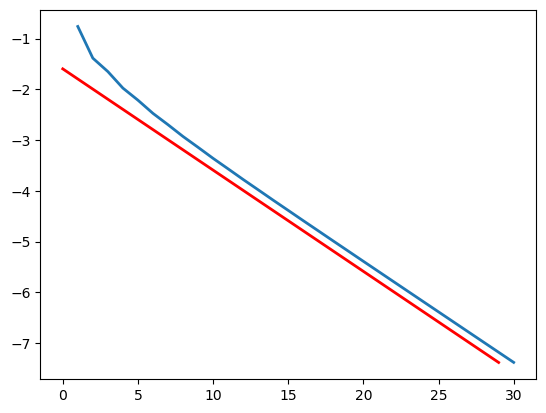

┌ Warning: Use of `Poly` from v1.0 forward will require `using Polynomials.PolyCompat`
│   caller = Poly at Poly.jl:26 [inlined]
└ @ Core /Users/davide/.julia/packages/Polynomials/ghqdF/src/polynomials/Poly.jl:26


In [34]:
fit = curve_fit(Poly, x[15:end], log.(SzSzval2[15:end]), 1)
y0b = fit.(x);
plot(x,log.(SzSzval2),y0b, "r-",linewidth=2.0);

In [35]:
# Correlation length
-1/fit[1]

5.010317245230092

$\xi$ depends on the maximum bond dimension $N_{\text{keep}}$. Indeed, in the limit of $N_{\text{keep}}\rightarrow\inf$, $\xi$ will converge to $\xi\approx6$ which is obtained by the extrapolation of finite-size DMRG calculation [S. R. White and D. A. Huse, Phys. Rev. B 48, 3844 (1993)].

# Orthogonalization


In the above demonstration of the spin-1 Heisenberg chain, the error for the dominant eigenvector is of order of $O(10^{-8})$. It seems good enough, but we can make tensors to yield numerically exact left- and right-normalized ket tensors, i.e., up to double precision!

For this, we need to "orthogonalize" the Lambda and Gamma tensors, following the method introduced in Sec. II of R. Orus & G. Vidal, Phys. Rev. B 78, 155117 (2008).

First check the old solution:

In [36]:
# Contract Gamma*Lambda*Gamma*Lambda
DL1 = zeros(length(Lambda1[1]),length(Lambda1[1]));
DL2 = zeros(length(Lambda1[2]),length(Lambda1[2]));
for i in 1:length(Lambda1[1])
    DL1[i,i] = Lambda1[1][i];
end
for i in 1:length(Lambda1[2])
    DL2[i,i] = Lambda1[2][i];
end
T = contract(Gamma1[1],3,[3],DL1,2,[1]);
T = contract(T,3,[3],Gamma1[2],3,[1]);
T = contract(T,4,[4],DL2,2,[1]);

# Transfer operator
W = contract(conj(T),4,[2 3],T,4,[2 3],[1 3 2 4]);
# Reshape W as matrix
MW = reshape(W,(size(W,1)*size(W,2),size(W,3)*size(W,4)));
DW,VW = eigen(MW);
DW = real(DW);
VW = real(VW);
ids = sortperm(DW,rev=true);
VW = VW[:,ids];
DW = DW[ids];
DW[1]-1

2.715605518233133e-13

In [37]:
# VW should be proportional to the identity if tensors are "orthogonal"
VM2 = reshape(VW[:,1],(size(W,1),size(W,2)));
# as the matrix VM2 is large, let's compare only the differences deviation from I
VM2diff = abs.((tr(VM2)/size(VM2,1))* Matrix(I, size(VM2,1), size(VM2,2)).-VM2);
mean(VM2diff[:])

1.6274630513684917e-8

We now perform orthogonalization on top of the previous results:

In [38]:
Lambda3,Gamma3 = canon_iMPS(Lambda1,Gamma1);

# Contract Gamma*Lambda*Gamma*Lambda
DL1 = zeros(length(Lambda3[1]),length(Lambda3[1]));
DL2 = zeros(length(Lambda3[2]),length(Lambda3[2]));
for i in 1:length(Lambda3[1])
    DL1[i,i] = Lambda3[1][i];
end
for i in 1:length(Lambda3[2])
    DL2[i,i] = Lambda3[2][i];
end
T = contract(Gamma3[1],3,[3],DL1,2,[1]);
T = contract(T,3,[3],Gamma3[2],3,[1]);
T = contract(T,4,[4],DL2,2,[1]);

# Transfer operator
W = contract(conj(T),4,[2 3],T,4,[2 3],[1 3 2 4]);
# Reshape W as matrix
MW = reshape(W,(size(W,1)*size(W,2),size(W,3)*size(W,4)));
DW,VW = eigen(MW);
DW = real(DW);
VW = real(VW);
ids = sortperm(DW,rev=true);
VW = VW[:,ids];
DW = DW[ids];
DW[1]-1

0.0

In [39]:
# VW should be proportional to the identity if tensors are "orthogonal"
VM2 = reshape(VW[:,1],(size(W,1),size(W,2)));
# as the matrix VM2 is large, let's compare only the differences deviation from I
VM2diff = abs.((tr(VM2)/size(VM2,1))* Matrix(I, size(VM2,1), size(VM2,2)).-VM2);
mean(VM2diff[:])

6.686508358688947e-16

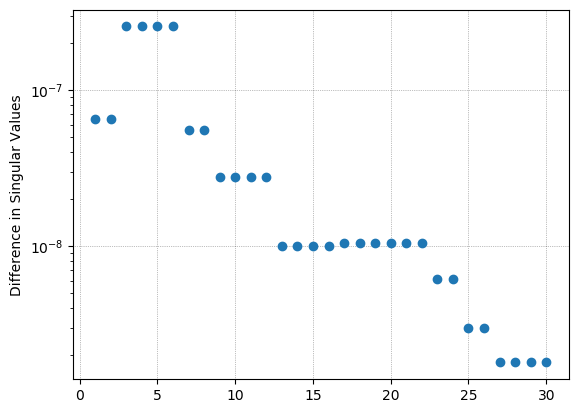

In [40]:
ydiff = abs.(Lambda1[1][:].-Lambda3[1][:]);
x = (1:1:length(ydiff));
ylabel("Difference in Singular Values");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
semilogy(x,ydiff,linewidth=0,marker="o");

While the singular values differ by $<10^{-7}$, the difference between the Gamma tensors can be huge:

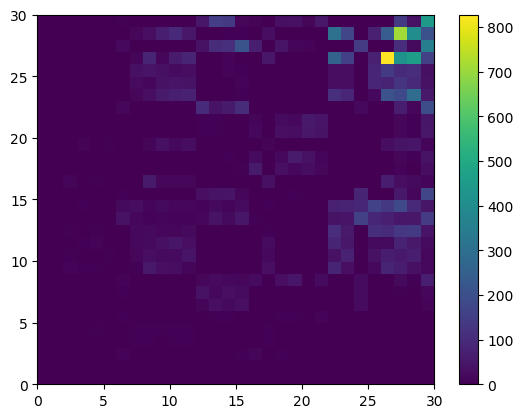

In [41]:
Gdiff = abs.(Gamma1[1]-Gamma3[1]);
Gdiff = reshape(mean(Gdiff,dims=2),(size(Gdiff,1),size(Gdiff,3)));
pcolormesh(Gdiff);
colorbar();

The difference is largest for the elements at the upper-left corner, which is associated with the smallest singular values. (Note that the singular values are sorted in ascending order.) These elements of Gamma are to be contracted with such small singular values.

The difference between Lambda*Gamma type tensors is:

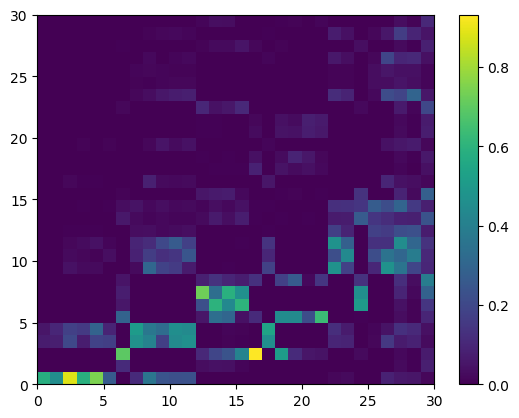

In [42]:
DL1 = zeros(length(Lambda1[1]),length(Lambda1[1]))
DL3 = zeros(length(Lambda3[1]),length(Lambda3[1]))
for i in 1:length(Lambda1[1])
   DL1[i,i] = Lambda1[1][i] 
end
for i in 1:length(Lambda3[1])
   DL3[i,i] = Lambda3[1][i] 
end

A1 = contract(DL1,2,[2],Gamma1[1],3,[1]);
A3 = contract(DL3,2,[2],Gamma3[1],3,[1]);
Adiff = abs.(A1-A3);
Adiff = reshape(mean(Adiff,dims=2),(size(Adiff,1),size(Adiff,3)));

pcolormesh(Adiff);
colorbar();